In [1]:
import pandas as pd
import numpy as np
dataset = pd.read_csv("../../Data/cleaned_v2.csv")
dataset

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Link,Content,Content_cleaned_v1,Length_cleaned_v1,Content_cleaned_v2,Length_cleaned_v2,Label,summary,cc
0,0,0.0,0,https://baomoi.com/pep-guardiola-soi-mau-haala...,"Đến làm khách Everton, Haaland có bàn thắng th...",đến làm_khách everton haaland có bàn thắng thứ...,266,làm_khách everton haaland bàn thắng thứ ngoại_...,175.0,The thao,"Đến làm_khách Everton , Haaland có bàn thắng t...",NaN
1,1,1.0,1,https://baomoi.com/mu-chieu-mo-hau-ve-da-nang-...,Mohamed Simakan là một trong những cầu thủ chơ...,mohamed simakan là một trong những cầu_thủ chơ...,199,mohamed simakan cầu_thủ chơi tốt rb leipzig mù...,124.0,The thao,Mohamed Simakan là một trong những cầu_thủ chơ...,NaN
2,2,2.0,2,https://baomoi.com/vet-gon-trong-chien-thang-c...,Barca để lại nhiều nỗi lo dù vừa lên ngôi tại...,barca để lại nhiều nỗi lo dù vừa lên_ngôi tại ...,715,barca nỗi lo dù vừa lên_ngôi la_liga ảnh reute...,503.0,The thao,Barca để lại nhiều nỗi lo dù vừa lên_ngôi tại ...,NaN
3,3,3.0,3,https://baomoi.com/sao-man-city-chon-messi-gia...,Bernardo Silva đánh giá Haaland chưa đủ khả n...,bernardo_silva đánh_giá haaland chưa đủ khả_nă...,292,bernardo_silva đánh_giá haaland chưa đủ khả_nă...,210.0,The thao,Bernardo_Silva đánh_giá Haaland chưa đủ khả_nă...,NaN
4,4,4.0,4,https://baomoi.com/sea-games-32-dau-kiem-mang-...,"(Ảnh minh họa. Minh Quyết/TTXVN) Trưa 15/5, tạ...",ảnh minh_họa minh_quyết ttxvn trưa tại khu nhà...,235,ảnh minh_họa minh_quyết ttxvn trưa khu thi_đấu...,166.0,The thao,( Ảnh minh_họa . Minh_Quyết / TTXVN ) Trưa 15 ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
22726,13637,NaN,13757,https://plo.vn/sap-xu-12-cuu-can-bo-o-dong-nai...,"Theo dự kiến, ngày 22-5 tới đây, TAND tỉnh Đồn...",theo dự_kiến ngày tới đây tand tỉnh đồng_nai s...,682,dự_kiến tới đây tand tỉnh đồng_nai mở phiên sơ...,519.0,Phap luat,NaN,"Theo dự_kiến , ngày 22 - 5 tới đây , TAND tỉnh..."
22727,13638,NaN,13758,https://plo.vn/vien-kiem-sat-thu-ky-cua-hoang-...,"Chiều 15-2, TAND TP.HCM tiếp tục xử sơ thẩm vụ...",chiều tand tp hcm tiếp_tục xử sơ_thẩm vụ án vi...,411,chiều tand tp hcm tiếp_tục xử sơ_thẩm vụ án vi...,276.0,Phap luat,NaN,"Chiều 15 - 2 , TAND TP. HCM tiếp_tục xử sơ_thẩ..."
22728,13639,NaN,13759,https://plo.vn/hotgirl-tina-duong-bi-phat-11-n...,"Chiều 9-6, TAND tỉnh Bình Thuận đã tuyên phạt ...",chiều tand tỉnh bình_thuận đã tuyên_phạt bị_cá...,313,chiều tand tỉnh bình_thuận tuyên_phạt bị_cáo n...,226.0,Phap luat,NaN,"Chiều 9 - 6 , TAND tỉnh Bình_Thuận đã tuyên_ph..."
22729,13640,NaN,13760,https://plo.vn/tand-tp-ca-mau-xin-loi-nguoi-bi...,"Chiều 2-3, TAND TP Cà Mau tổ chức buổi xin lỗi...",chiều tand tp cà_mau tổ_chức buổi xin_lỗi ngườ...,661,chiều tand tp cà_mau tổ_chức buổi xin_lỗi oan ...,449.0,Phap luat,NaN,"Chiều 2 - 3 , TAND TP Cà_Mau tổ_chức buổi xin_..."


In [2]:
# w2v = KeyedVectors.load_word2vec_format("../../Data/baomoi.window2.vn.model.bin.gz", binary=True)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('validation.csv')

In [31]:
X_train, Y_train = train["Content_cleaned_v2"], train["Label"]
X_test, Y_test = test["Content_cleaned_v2"], test["Label"]
X_val, Y_val = val["Content_cleaned_v2"], val["Label"]

In [32]:
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)
Y_val = pd.get_dummies(Y_val)

In [23]:
X_train.shape, Y_train.shape,X_test.shape, Y_test.shape,X_val.shape, Y_val.shape

((15911,), (15911, 9), (6820,), (6820, 9), (2000,), (2000, 9))

In [ ]:
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from preprocessing import Preprocesser

class TextPreprocessor:
    def __init__(self, tokenizer_path, max_sequence_length):
        self.tokenizer_path = tokenizer_path
        self.max_sequence_length = max_sequence_length
        self.tokenizer = None

    def load_tokenizer(self):
        with open(self.tokenizer_path, 'rb') as f:
            self.tokenizer = pickle.load(f)

    def preprocess_text(self, text):
        if not self.tokenizer:
            self.load_tokenizer()
        sequence = self.tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, maxlen=self.max_sequence_length)
        return padded_sequence

class LSTMPipeline:
    def __init__(self, model_path, tokenizer_path, max_sequence_length):
        self.model_path = model_path
        self.tokenizer_path = tokenizer_path
        self.max_sequence_length = max_sequence_length
        self.model = None
        self.preprocessor = TextPreprocessor(tokenizer_path, max_sequence_length)
        self.tokenizer = Preprocesser()
    def load_model(self):
        self.model = load_model(self.model_path)

    def predict(self, text):
        if not self.model:
            self.load_model()
        text = self.tokenizer.transform(text)
        padded_sequence = self.preprocessor.preprocess_text(text)
        predictions = self.model.predict(padded_sequence)
        return predictions

# Define the paths and parameters
model_path = 'lstm2.h5'
tokenizer_path = 'tokenizer.pkl'
max_sequence_length = 100

# Create an instance of the pipeline
pipeline = LSTMPipeline(model_path, tokenizer_path, max_sequence_length)

# Make predictions
text = 'example sentence for prediction'
predictions = pipeline.predict(text)


In [24]:
from keras_preprocessing.text import Tokenizer
import pickle
from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')

tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# X = sequence.pad_sequences(sequences, maxlen=maxlen)
# Y = pd.get_dummies(Y_train)

In [14]:
from gensim.models import Word2Vec, KeyedVectors
w2v = Word2Vec.load("../../FeatureEngineering/Vectorize/w2vmodel_skip.model")

In [25]:
import numpy as np
notin = []
embedding_dim = 128
maxlen = 350
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
print('num_words:', num_words)
for word, i in word_index.items():
    if word in w2v.wv.key_to_index:
            embedding_matrix[i] = w2v.wv[word]
    else:
        notin.append(word)

num_words: 57132


In [33]:
tokenizer.word_index

{'nên': 1,
 'thời_gian': 2,
 'cả': 3,
 'triệu': 4,
 'mức': 5,
 'đầu_tư': 6,
 'chưa': 7,
 'tỉnh': 8,
 'sử_dụng': 9,
 'hoạt_động': 10,
 'lần': 11,
 'nói': 12,
 'lớn': 13,
 'cô': 14,
 'vì': 15,
 'hay': 16,
 'bên': 17,
 'xây_dựng': 18,
 'so': 19,
 'đạt': 20,
 'đối_với': 21,
 'rằng': 22,
 'doanh_nghiệp': 23,
 'điều': 24,
 'ngành': 25,
 'kinh_tế': 26,
 'công_ty': 27,
 'bằng': 28,
 'nếu': 29,
 'tp': 30,
 'thứ': 31,
 'hoặc': 32,
 'thấy': 33,
 'tỷ': 34,
 'giáo_dục': 35,
 'cấp': 36,
 'điểm': 37,
 'tiếp_tục': 38,
 'bạn': 39,
 'gần': 40,
 'con': 41,
 'một_số': 42,
 'tạo': 43,
 'quy_định': 44,
 'đầu': 45,
 'xã_hội': 46,
 'họ': 47,
 'tuổi': 48,
 'y_tế': 49,
 'thông_tin': 50,
 'đưa': 51,
 'học_sinh': 52,
 'thị_trường': 53,
 'tiền': 54,
 'cơ_sở': 55,
 'thi': 56,
 'tốt': 57,
 'dự_án': 58,
 'thêm': 59,
 'học': 60,
 'tuy_nhiên': 61,
 'khoảng': 62,
 'ngân_hàng': 63,
 'vàng': 64,
 'chương_trình': 65,
 'từng': 66,
 'giúp': 67,
 'đặc_biệt': 68,
 'bà': 69,
 'giữa': 70,
 'nghiên_cứu': 71,
 'bệnh': 72,
 'mỗi': 

In [ ]:
# len([i for i in embedding_matrix if np.mean(i) != 0]), len(notin)

In [ ]:
# two = []
# one = []
# more = []
# for i in notin:
#   leng = len(i.split('_'))
#   if leng == 2:
#     two.append(i)
#     continue
#   if leng == 1:
#     one.append(i)
#     continue
#   more.append(i)

In [ ]:
# len(one), len(two), len(more)

In [ ]:
# "|".join(more)

In [27]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, Dropout

model1 = Sequential()
model1.add(Embedding(num_words, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model1.add(Bidirectional(LSTM(units=128, return_sequences= True)))
model1.add(Dropout(0.1))
model1.add(Bidirectional(LSTM(units=64, return_sequences= False)))
model1.add(Dropout(0.2))
model1.add(Dense(units=64, activation='relu'))
model1.add(Dense(units=16, activation='relu'))
model1.add(Dense(9, activation='softmax')) 
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

2023-06-20 15:39:43.514471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 128)          7312896   
                                                                 
 bidirectional (Bidirectiona  (None, 350, 256)         263168    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 350, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

In [ ]:
# from keras.callbacks import EarlyStopping
# callback1 = EarlyStopping(monitor = "val_accuracy", patience= 4)
# callback2 = EarlyStopping(monitor = "val_loss", patience= 4)

In [30]:
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))

In [34]:
from keras_preprocessing import sequence

In [35]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(X_train, maxlen)

In [36]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = sequence.pad_sequences(X_val, maxlen)

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model_skip.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [43]:
model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs= 50, batch_size=16, callbacks=[checkpoint])

Epoch 1/50
995/995 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.6382
Epoch 1: val_loss improved from inf to 0.13688, saving model to best_model_skip.h5
995/995 [==============================] - 481s 483ms/step - loss: 0.2033 - accuracy: 0.6382 - val_loss: 0.1369 - val_accuracy: 0.7665
Epoch 2/50
995/995 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.7468
Epoch 2: val_loss improved from 0.13688 to 0.11592, saving model to best_model_skip.h5
995/995 [==============================] - 502s 505ms/step - loss: 0.1467 - accuracy: 0.7468 - val_loss: 0.1159 - val_accuracy: 0.8065
Epoch 3/50
995/995 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.8060
Epoch 3: val_loss improved from 0.11592 to 0.10869, saving model to best_model_skip.h5
995/995 [==============================] - 516s 519ms/step - loss: 0.1150 - accuracy: 0.8060 - val_loss: 0.1087 - val_accuracy: 0.8200
Epoch 4/50
995/995 [==============================

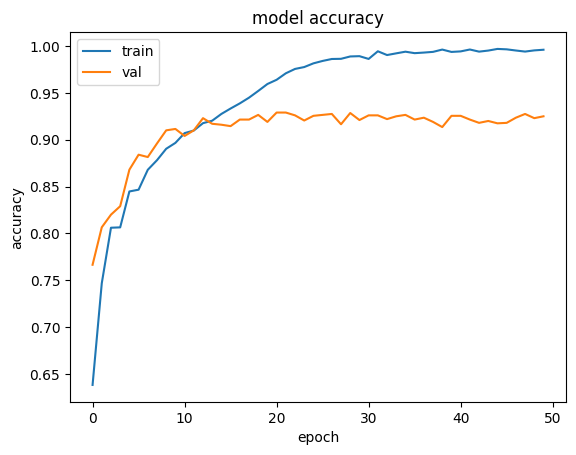

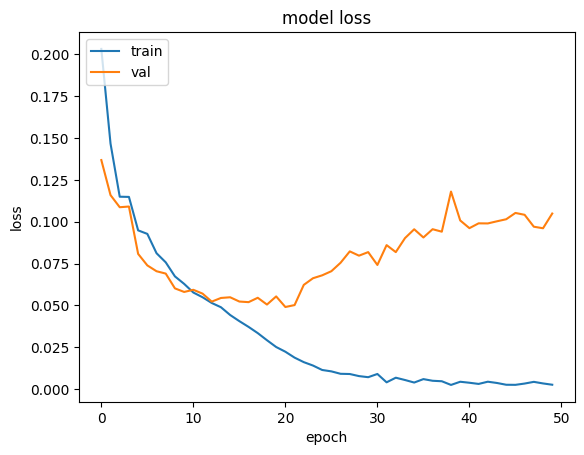

In [44]:
from matplotlib import pyplot as plt
plt.plot(model1.history.history['accuracy'])
plt.plot(model1.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
from matplotlib import pyplot as plt
plt.plot(model1.history.history['loss'])
plt.plot(model1.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
from keras.models import load_model

In [46]:
model_saved = load_model('best_model_skip.h5')

In [47]:
Y_test = pd.get_dummies(Y_test)

In [49]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test, maxlen)

In [50]:
loss, accuracy = model_saved.evaluate(X_test, Y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

214/214 [==============================] - 55s 241ms/step - loss: 0.0546 - accuracy: 0.9214
Test Loss: 0.054560307413339615
Test Accuracy: 0.9214076399803162


In [ ]:
y_pred = model1.predict(X_test)

In [ ]:
# predicted = y_pred.argmax(axis=1)

In [ ]:
# true_labels = Y_test.values.argmax(axis=1)

In [ ]:
# true_labels

In [ ]:
# predicted

In [ ]:
# arr_wrong = []
# for i, v in enumerate(predicted):
#   if v != true_labels[i]:
#     arr_wrong.append(i)

In [ ]:
# arr_true = []
# for i, v in enumerate(predicted):
#   if v == true_labels[i]:
#     arr_true.append(i)

In [ ]:
# w = tokenizer.sequences_to_texts(predicted[arr_wrong])

In [ ]:
# t = tokenizer.sequences_to_texts(true_labels[arr_true])

In [ ]:
# length_w = pd.Series(sorted([len(l.split()) for l in w]))

In [ ]:
# length_t = pd.Series(sorted([len(l.split()) for l in t]))

In [ ]:
# len(length_w)

In [ ]:
# len(length_t)

In [ ]:
# length_t.plot()

In [ ]:
# length_w.plot()

In [ ]:
# len(length_w[length_w.values < 50])

In [ ]:
# len(length_t[length_t.values < 50])

In [ ]:
# y_pred[arr_wrong]

In [ ]:
# predicted[arr_wrong]

In [ ]:
# true_labels[arr_wrong]

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def heatconmat(y_pred, y_test):
  plt.figure(figsize=(10,8))
  cnf_matrix = confusion_matrix(y_pred, y_test)
  ax = sns.heatmap(cnf_matrix, annot=True, fmt='', cmap='Blues')
  ax.xaxis.set_ticklabels(list(set(data[])))
  ax.yaxis.set_ticklabels(list(set(y_test)))
  plt.show()
heatconmat(predicted, true_labels)

In [ ]:
# check = pd.read_csv("../MachineLearning/.svm_predict.csv")
# se_check = tokenizer.texts_to_sequences(check['content'])

# maxlen = 300
# x_check = sequence.pad_sequences(se_check, maxlen=maxlen)

In [ ]:
# check_pred = model1.predict(x_check)

In [ ]:
# Y.columns

In [ ]:
# arr_wrong[40:50], check_pred[arr_wrong][40:50]

In [ ]:
# check_test = pd.get_dummies(check['true label'])

In [ ]:
# model1.evaluate(x_check, test_check)